In [2]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import cx_Oracle
import csv
warnings.filterwarnings('ignore')
plt.style.use('seaborn')
plt.rc('font', family = 'malgun gothic')
plt.rcParams['axes.unicode_minus'] = False

# # 지수화
---

## # 단순선형회귀
---
- 다른 방법을 쓰기로 함

In [10]:
# 계절성 보정 사용자 함수 (기수 버전)

def new_seasonal_scaled(df):
    df1 = df.copy()
    df1.loc[df1['기'] == '1기', '총구매액'] = np.round(df1.loc[df1['기'] == '1기', '총구매액'] / 0.9476399112)
    df1.loc[df1['기'] == '2기', '총구매액'] = np.round(df1.loc[df1['기'] == '2기', '총구매액'] / 0.9785290501)    
    df1.loc[df1['기'] == '3기', '총구매액'] = np.round(df1.loc[df1['기'] == '3기', '총구매액'] / 0.9072731695)    
    df1.loc[df1['기'] == '4기', '총구매액'] = np.round(df1.loc[df1['기'] == '4기', '총구매액'] / 1.166557869)    
    df1.loc[df1['기'] == '5기', '총구매액'] = np.round(df1.loc[df1['기'] == '5기', '총구매액'] / 0.9748289537)    
    df1.loc[df1['기'] == '6기', '총구매액'] = np.round(df1.loc[df1['기'] == '6기', '총구매액'] / 0.9784250528)    
    df1.loc[df1['기'] == '7기', '총구매액'] = np.round(df1.loc[df1['기'] == '7기', '총구매액'] / 0.912781587)    
    df1.loc[df1['기'] == '8기', '총구매액'] = np.round(df1.loc[df1['기'] == '8기', '총구매액'] / 1.133964406)
    df1['총구매액'] = df1['총구매액'].astype('int64')
    return df1

In [3]:
# 고정고객

con = cx_Oracle.connect('LM_PDB/LM@localhost:1521/xepdb1')
cursor = con.cursor()
sql = '''SELECT a.고객번호, a.성별, a.연령대, a.지역, a.세분류명, a.분류, b.고객구분, a.기, sum(a.구매금액) "총구매액"
FROM LCL2 a
JOIN 고정고객 b ON a.고객번호 = b.고객번호
GROUP BY a.고객번호, a.성별, a.연령대, a.지역, a.세분류명, a.분류, b.고객구분, a.기
ORDER BY a.고객번호, a.성별, a.연령대, a.지역, a.세분류명, a.분류, b.고객구분, a.기'''
cursor.execute(sql)
x = cursor.fetchall()
columns = ['고객번호', '성별', '연령대', '지역', '세분류명', '분류', '고객구분', '기', '총구매액']
df_all = pd.DataFrame(x, columns = columns)
cursor.close()
con.commit()
con.close()

display(df_all.head())

,고객번호,성별,연령대,지역,세분류명,분류,고객구분,기,총구매액
0,00001,M,60세이상,서울,선매품,가구/인테리어,감소,1기,177650
1,00001,M,60세이상,서울,선매품,가구/인테리어,감소,3기,63840
2,00001,M,60세이상,서울,선매품,가구/인테리어,감소,4기,4706400
3,00001,M,60세이상,서울,선매품,가구/인테리어,감소,5기,85500
4,00001,M,60세이상,서울,선매품,가구/인테리어,감소,6기,491750


In [4]:
df_all

,고객번호,성별,연령대,지역,세분류명,분류,고객구분,기,총구매액
0,00001,M,60세이상,서울,선매품,가구/인테리어,감소,1기,177650
1,00001,M,60세이상,서울,선매품,가구/인테리어,감소,3기,63840
2,00001,M,60세이상,서울,선매품,가구/인테리어,감소,4기,4706400
3,00001,M,60세이상,서울,선매품,가구/인테리어,감소,5기,85500
4,00001,M,60세이상,서울,선매품,가구/인테리어,감소,6기,491750
...,...,...,...,...,...,...,...,...,...
1171313,19337,M,20세~24세,서울,편의품,일상용품,증가,4기,38710
1171314,19337,M,20세~24세,서울,편의품,일상용품,증가,5기,21680
1171315,19337,M,20세~24세,서울,편의품,일상용품,증가,6기,1170
1171316,19337,M,20세~24세,서울,편의품,일상용품,증가,7기,15610


In [172]:
df_all_scaled = new_seasonal_scaled(df_all)
df_all_scaled1 = df_all_scaled[['고객번호', '분류', '기', '총구매액']]

In [173]:
b = df_all_scaled1.loc[(df_all_scaled1['고객번호'] == '00091') & (df_all_scaled1['분류'] == '가구/인테리어')]
b

,고객번호,분류,기,총구매액
5184,00091,가구/인테리어,1기,42210
5185,00091,가구/인테리어,7기,646376
5186,00091,가구/인테리어,8기,74517


<AxesSubplot:>

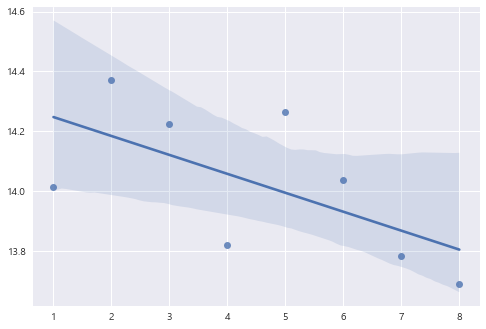

In [174]:
a = df_all_scaled1.loc[(df_all_scaled1['고객번호'] == '00091') & (df_all_scaled1['분류'] == '신선식품')]
a['기수'] = range(1, 9)
a
a['총구매액1'] = np.log1p(a['총구매액'])
np.polyfit(a['기수'], a['총구매액1'], 1)

X = np.array(a['기수']).reshape(1, -1)
y = np.array(a['총구매액1']).reshape(1, -1)

sns.regplot(X, y)

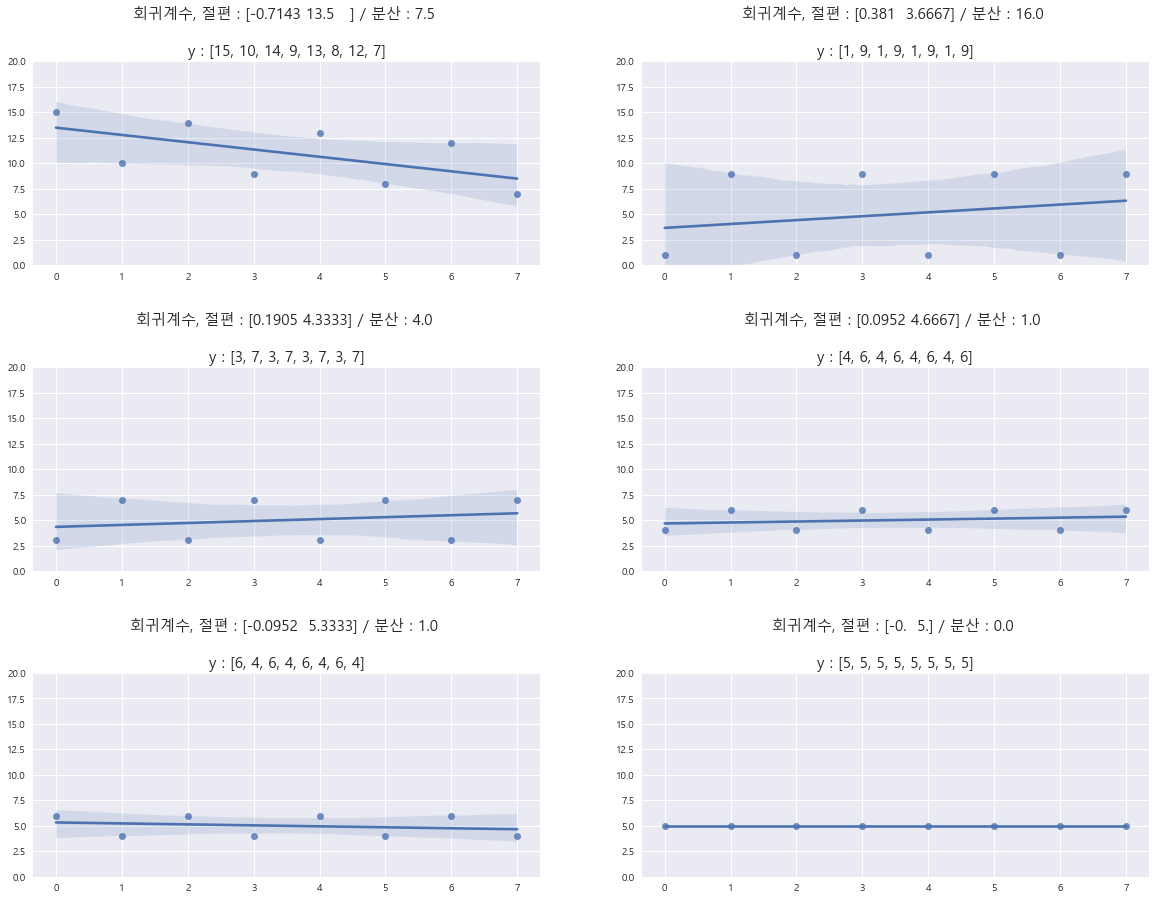

In [184]:
a = [15, 10, 14, 9, 13, 8, 12, 7]
b = [1, 9, 1, 9, 1, 9, 1, 9]
c = [3, 7, 3, 7 ,3, 7, 3, 7]
d = [4, 6, 4, 6, 4, 6, 4, 6]
e = [6, 4, 6, 4, 6, 4, 6, 4]
f = [5, 5, 5, 5, 5, 5, 5, 5]

x = [0, 1, 2, 3, 4, 5, 6, 7]

fig = plt.figure(figsize = (20, 15))
for i, y in enumerate([a, b, c, d, e, f]):
    fig.add_subplot(3, 2, i+1)
    sns.regplot(x, y)
    plt.title(f'회귀계수, 절편 : {np.round(np.polyfit(x, y, 1), 4)} / 분산 : {np.var(y)} \n\ny : {y}', fontsize = 15)
    plt.ylim(0, 20)
    
plt.subplots_adjust(hspace = 0.5)

In [181]:
np.mean(a)

5.0

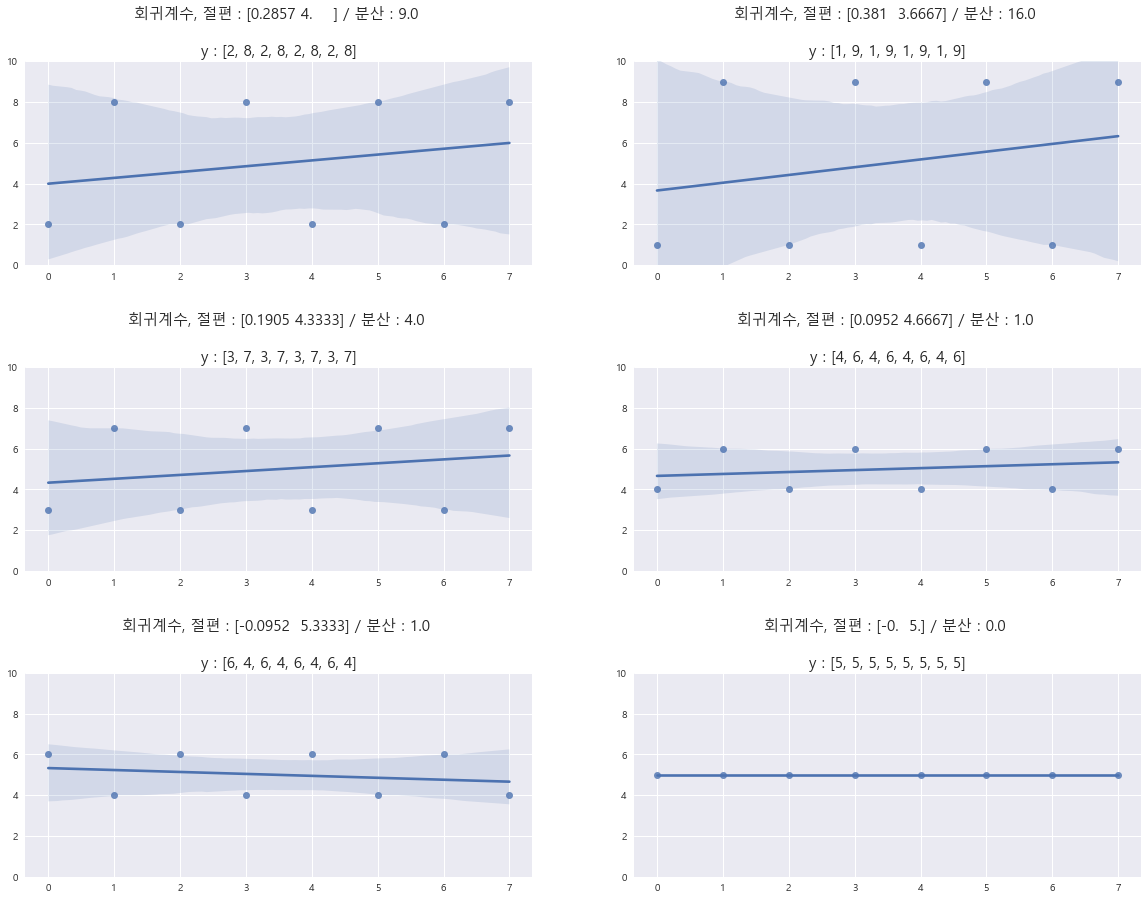

In [165]:
a = [2, 8, 2, 8, 2, 8, 2, 8]
b = [1, 9, 1, 9, 1, 9, 1, 9]
c = [3, 7, 3, 7 ,3, 7, 3, 7]
d = [4, 6, 4, 6, 4, 6, 4, 6]
e = [6, 4, 6, 4, 6, 4, 6, 4]
f = [5, 5, 5, 5, 5, 5, 5, 5]

x = [0, 1, 2, 3, 4, 5, 6, 7]

fig = plt.figure(figsize = (20, 15))
for i, y in enumerate([a, b, c, d, e, f]):
    fig.add_subplot(3, 2, i+1)
    sns.regplot(x, y)
    plt.title(f'회귀계수, 절편 : {np.round(np.polyfit(x, y, 1), 4)} / 분산 : {np.var(y)} \n\ny : {y}', fontsize = 15)
    plt.ylim(0, 10)
    
plt.subplots_adjust(hspace = 0.5)

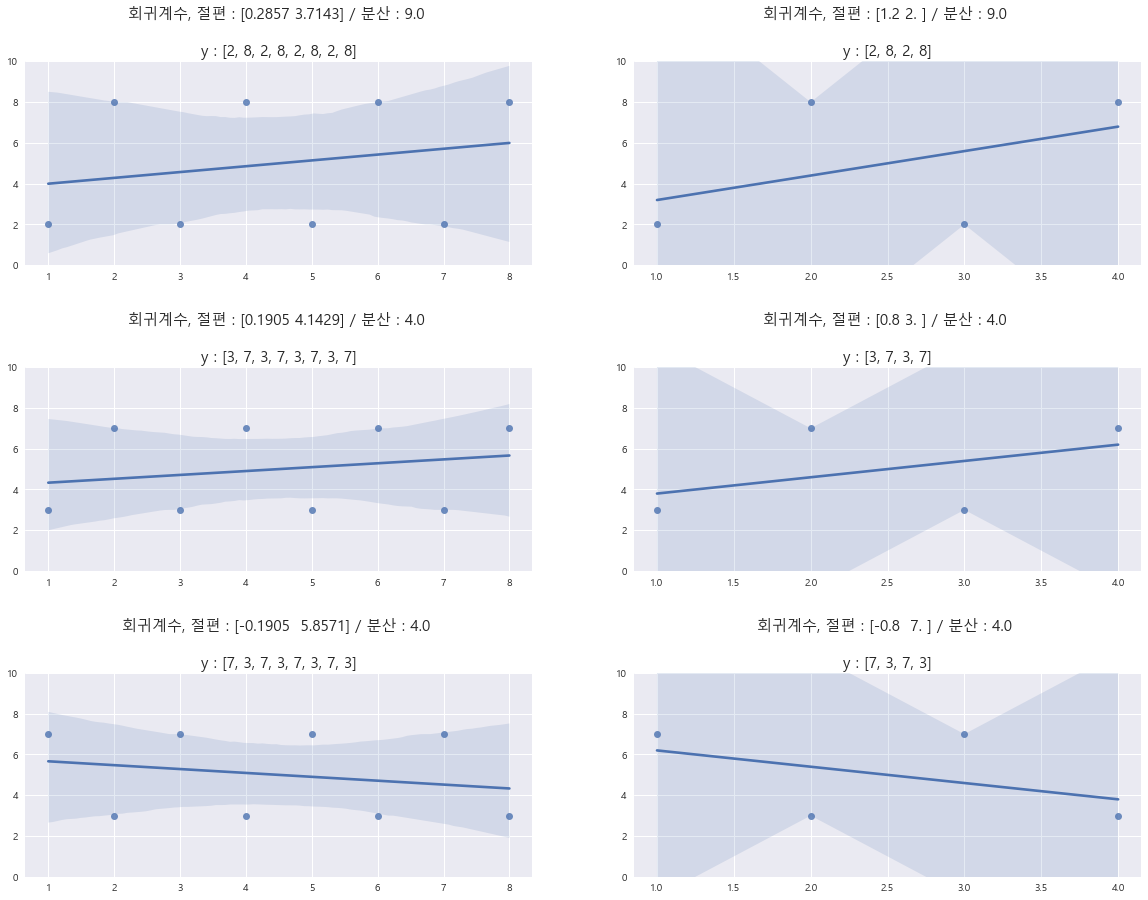

In [164]:
a = [2, 8, 2, 8, 2, 8, 2, 8]
b = [2, 8, 2, 8]
c = [3, 7, 3, 7 ,3, 7, 3, 7]
d = [3, 7, 3, 7]
e = [7, 3, 7, 3, 7, 3, 7, 3]
f = [7, 3, 7, 3]

x = [1, 2, 3, 4, 5, 6, 7, 8]
x1 = [1, 2, 3, 4]

fig = plt.figure(figsize = (20, 15))
for i, y in enumerate([a, b, c, d, e, f]):
    if y == a or y == c or y == e:
        fig.add_subplot(3, 2, i+1)
        plt.title(f'회귀계수, 절편 : {np.round(np.polyfit(x, y, 1), 4)} / 분산 : {np.var(y)} \n\ny : {y}', fontsize = 15)
        plt.ylim(0, 10)
        sns.regplot(x, y)
    elif y == b or y == d or y == f:
        fig.add_subplot(3, 2, i+1)
        plt.title(f'회귀계수, 절편 : {np.round(np.polyfit(x1, y, 1), 4)} / 분산 : {np.var(y)} \n\ny : {y}', fontsize = 15)
        plt.ylim(0, 10)
        sns.regplot(x1, y)

plt.subplots_adjust(hspace = 0.5)
plt.show()

In [158]:
def Standard(list_):
    new_list = []
    for i in list_:
        standard = StandardScaler().fit_transform(np.array(i).reshape(-1, 1))
        new_list.append(standard.reshape(-1))
    return new_list

def MinMax(list_):
    new_list = []
    for i in list_:
        minmax = MinMaxScaler().fit_transform(np.array(i).reshape(-1, 1))
        new_list.append(minmax.reshape(-1))
    return new_list

def Log(list_):
    new_list = []
    for i in list_:
        log = np.log1p(i)
        new_list.append(log)    
    return new_list
#         return new_list[i]

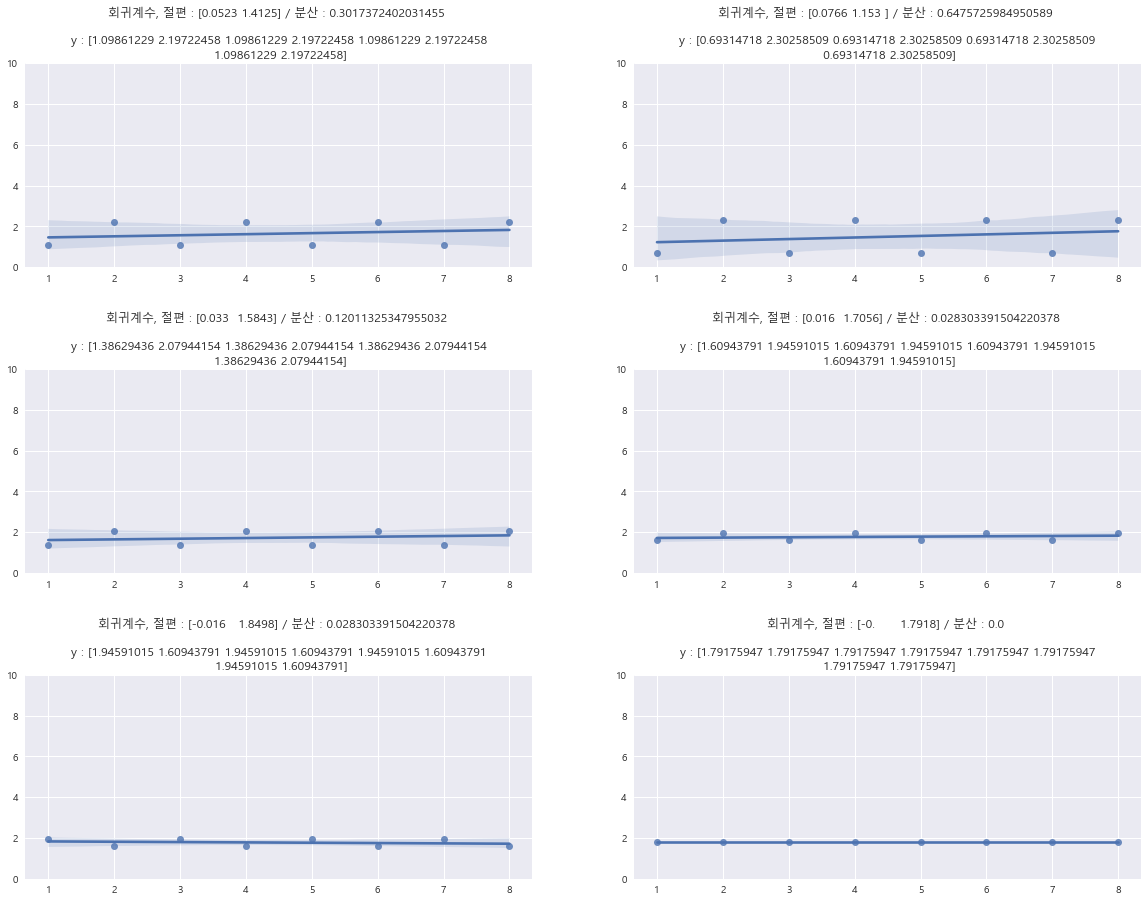

In [122]:
fig = plt.figure(figsize = (20, 15))

for i, y in enumerate(Log([a, b, c, d, e, f])):
    fig.add_subplot(3, 2, i+1)
    sns.regplot(x, y)
    plt.title(f'회귀계수, 절편 : {np.round(np.polyfit(x, y, 1), 4)} / 분산 : {np.var(y)} \n\ny : {y}')
    plt.ylim(0, 10)
    
plt.subplots_adjust(hspace = 0.5)

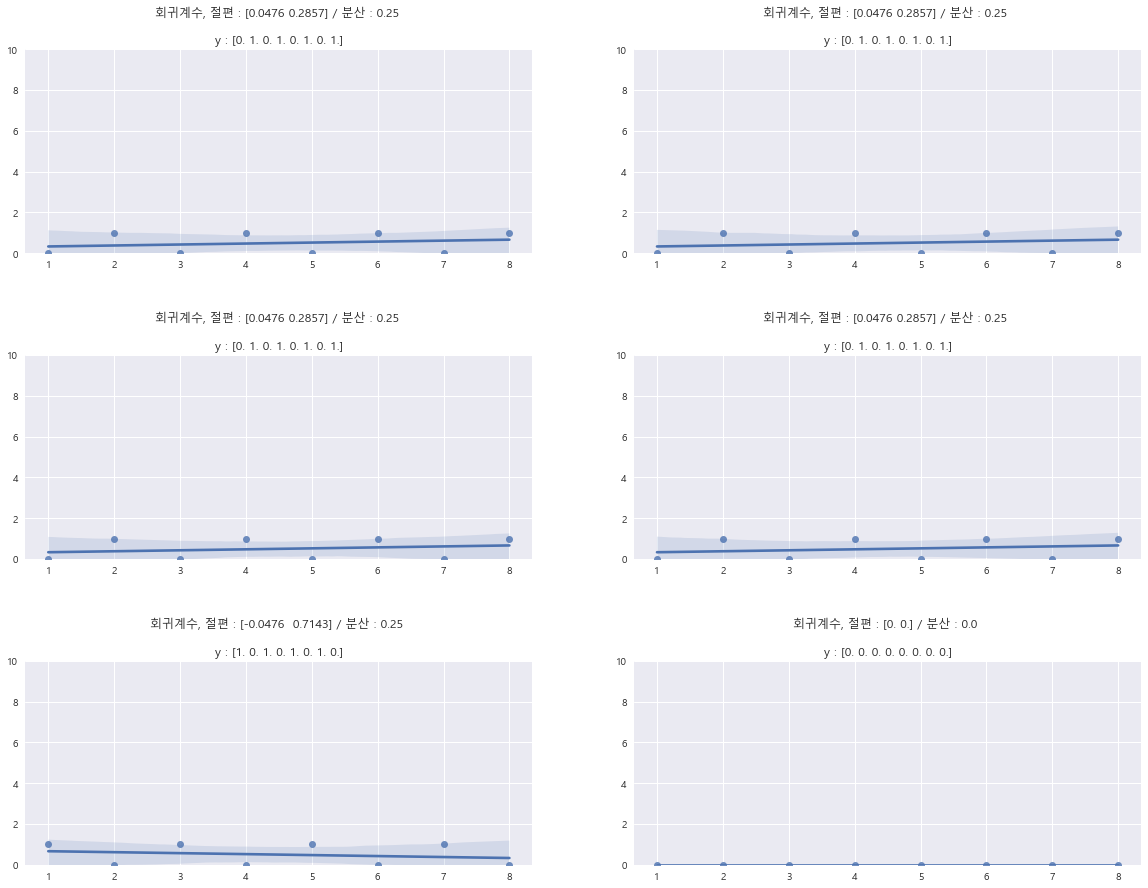

In [160]:
# 민맥스스케일러

fig = plt.figure(figsize = (20, 15))

for i, y in enumerate(MinMax([a, b, c, d, e, f])):
    fig.add_subplot(3, 2, i+1)
    sns.regplot(x, y)
    plt.title(f'회귀계수, 절편 : {np.round(np.polyfit(x, y, 1), 4)} / 분산 : {np.var(y)} \n\ny : {y}')
    plt.ylim(0, 10)
    
plt.subplots_adjust(hspace = 0.5)

In [161]:
# [3, 7, 3, 7, 3, 7, 3, 7]
print(((3*0.4) + (7*0.4/2)) + ((7*-0.4/2) + (3*-0.4/2)) + ((3*0.4/2) + (7*0.4/2)) + ((7*-0.4/2) + (3*0.4/2)) + ((3*-0.4/2) + (7*0.4/2)) + ((7*-0.4/2) + (3*-0.4/2)) + ((3*0.4/2) + (7*0.4)))
# [3, 7, 3, 7]
print(((3*0.4) + (7*0.4/2)) + ((7*-0.4/2) + (3*-0.4/2)) + ((3*0.4/2) + (7*0.4)))


print(((4*0.2) + (6*0.2/2)) + ((6*-0.2/2) + (4*-0.2/2)) + ((4*0.2/2) + (6*0.2/2)) + ((6*-0.2/2) + (4*-0.2/2)) + ((4*0.2/2) + (6*0.2/2)) + ((6*-0.2/2) + (4*-0.2/2)) + ((4*0.2/2) + (6*0.2)))
print(((4*0.2) + (6*0.2/2)) + ((6*-0.2/2) + (4*-0.2/2)) + ((4*0.2/2) + (6*0.2)))

print(((7*-0.4) + (3*-0.4/2)) + ((3*0.4/2) + (7*0.4/2)) + ((7*-0.4/2) + (3*-0.4/2)) + ((3*0.4/2) + (7*0.4)) + ((7*-0.4/2) + (3*-0.4/2)) + ((3*0.4/2) + (7*0.4/2)) + ((7*-0.4/2) + (3*-0.4)))
print(((7*-0.4) + (3*-0.4/2)) + ((3*0.4/2) + (7*0.4/2)) + ((7*-0.4/2) + (3*-0.4)))

4.000000000000001
4.000000000000001
2.0
2.0
-2.6000000000000005
-4.000000000000001


In [116]:
np.polyfit(a['기수'], a['총구매액1'], 1)

np.var(a['총구매액1'])

0.05356698427910005

<AxesSubplot:>

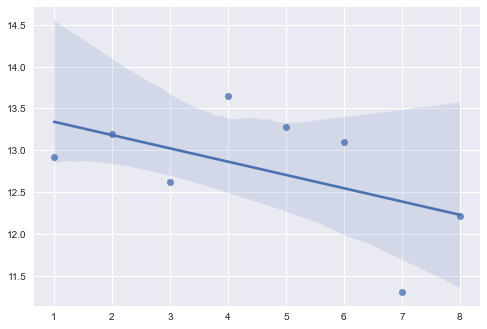

In [99]:
a = df_all_scaled1.loc[(df_all_scaled1['고객번호'] == '00001') & (df_all_scaled1['분류'] == '신선식품')]
a['기수'] = range(1, 9)
a
a['총구매액1'] = np.log1p(a['총구매액'])
np.polyfit(a['기수'], a['총구매액1'], 1)

X = np.array(a['기수']).reshape(1, -1)
y = np.array(a['총구매액1']).reshape(1, -1)

sns.regplot(X, y)

1.0

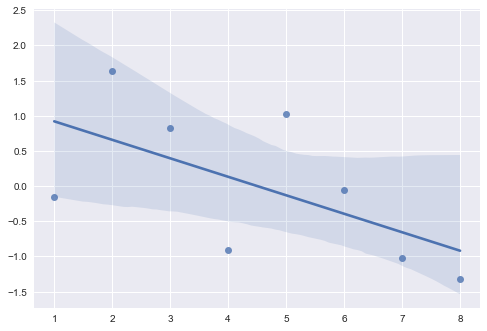

In [118]:
a['총구매액1'] = StandardScaler().fit_transform(np.array(a['총구매액']).reshape(-1, 1))

X = np.array(a['기수']).reshape(1, -1)
y = np.array(a['총구매액1']).reshape(1, -1)

sns.regplot(X, y)
np.var(y)

In [ ]:
con = cx_Oracle.connect('LM_PDB/LM@localhost:1521/xepdb1')
cursor = con.cursor()
sql ='''select a.고객번호, 분류, 고객구분, sum(구매금액), 기 from lcl2 a
join 고정고객 b on a.고객번호 = b.고객번호
group by a.고객번호, 분류, 고객구분, 기'''
cursor.execute(sql)
x = cursor.fetchall()
columns = ['고객번호','분류', '고객구분', '총구매액', '기']
df2 = pd.DataFrame(x,columns=columns)
display(df2)
cursor.close()
con.commit()
con.close()

df2_scaled = new_seasonal_scaled(df2)

In [13]:
df2_scaled = new_seasonal_scaled(df2)

In [28]:
a = df2_scaled[df2_scaled['기'] == '1기'][['고객번호', '총구매액']]

In [5]:
# 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 실루엣 계수를 면적으로 시각화한 함수 작성

def visualize_silhouette(cluster_lists, X_features, max_iter): 
    
    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math
    
    n_cols = 4
    n_rows = int(np.ceil(len(cluster_lists)/4))
    
    fig = plt.figure(figsize = (25, 8*n_rows))
    plt.subplots_adjust(hspace = 0.35)
#     plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.35)  # 서브플롯 공간 띄우기
    for ind, n_cluster in enumerate(cluster_lists):
        clusterer = KMeans(n_clusters = n_cluster, max_iter = max_iter, random_state = 0)
        cluster_labels = clusterer.fit_predict(X_features)
        
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
        
        y_lower = 10
        ax = fig.add_subplot(n_rows, n_cols, ind+1)
        ax.set_title(f'\
            max_iter : {str(max_iter)} \n\n \
            Number of Cluster : {str(n_cluster)} \n \
            Silhouette Score : {str(round(sil_avg,3))}')
        ax.set_xlabel("The silhouette coefficient values")
        ax.set_ylabel("Cluster label")
        ax.set_xlim([-0.1, 1])
        ax.set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        ax.set_yticks([])  # Clear the yaxis labels / ticks
        ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        
        # 클러스터링 갯수별로 fill_betweenx()형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
            
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.nipy_spectral(float(i) / n_cluster)
            ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
            
        ax.axvline(x=sil_avg, color="red", linestyle="--")

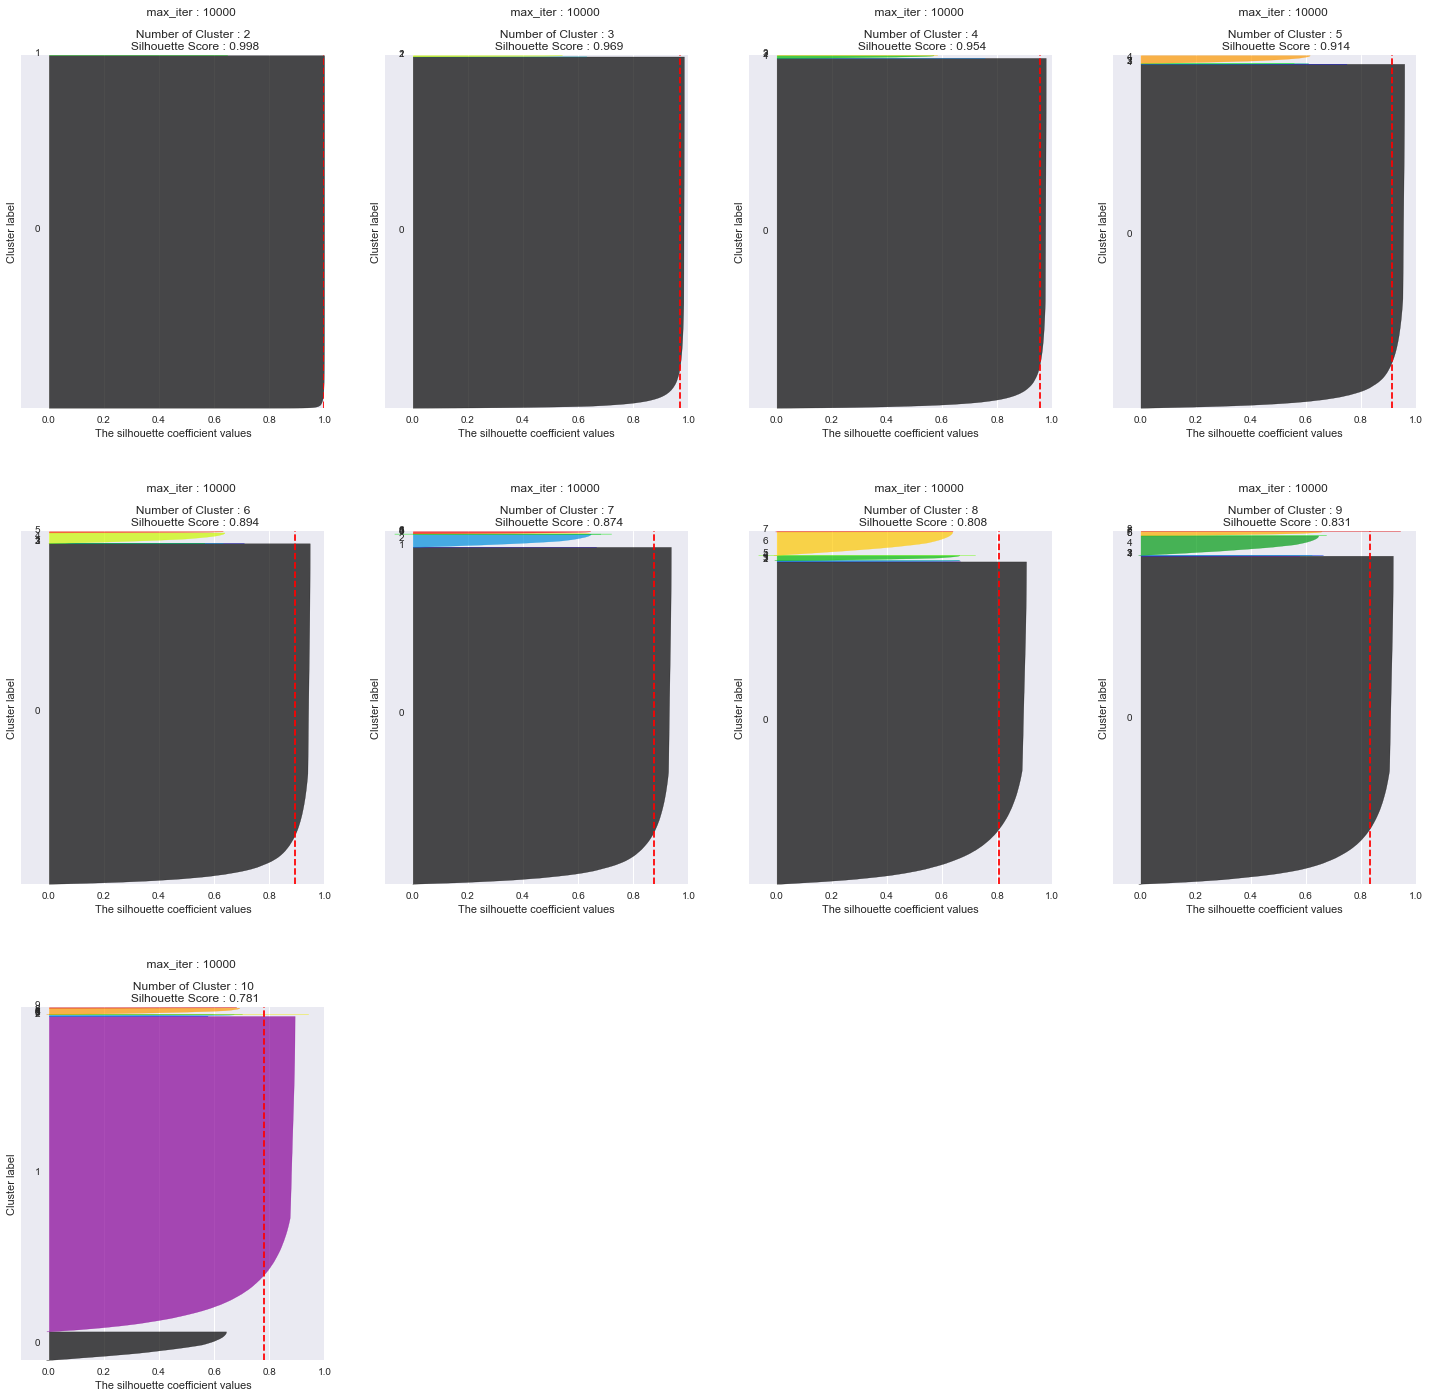

In [29]:
cluster_lists = [2, 3, 4, 5, 6, 7, 8, 9, 10]
max_iter = 10000

visualize_silhouette(cluster_lists, a, max_iter)

## # 등급법
---

### # 구매액 지수화
---

In [8]:
# 고정고객

con = cx_Oracle.connect('LM_PDB/LM@localhost:1521/xepdb1')
cursor = con.cursor()
sql = '''SELECT a.고객번호, a.분류, b.고객구분, a.기, sum(a.구매금액) "총구매액"
FROM LCL2 a
JOIN 고정고객 b ON a.고객번호 = b.고객번호
GROUP BY a.고객번호, a.분류, b.고객구분, a.기
ORDER BY a.고객번호, a.분류, b.고객구분, a.기'''
cursor.execute(sql)
x = cursor.fetchall()
columns = ['고객번호','분류', '고객구분', '기', '총구매액']
df_all = pd.DataFrame(x, columns = columns)
cursor.close()
con.commit()
con.close()

display(df_all.head())

,고객번호,분류,고객구분,기,총구매액
0,00001,가공식품,감소,1기,1208630
1,00001,가공식품,감소,2기,2272010
2,00001,가공식품,감소,3기,385520
3,00001,가공식품,감소,4기,461470
4,00001,가공식품,감소,5기,399740


In [11]:
# 계절성 보정 사용자 함수 (기수 버전)

def new_seasonal_scaled(df):
    df1 = df.copy()
    df1.loc[df1['기'] == '1기', '총구매액'] = np.round(df1.loc[df1['기'] == '1기', '총구매액'] / 0.9476399112)
    df1.loc[df1['기'] == '2기', '총구매액'] = np.round(df1.loc[df1['기'] == '2기', '총구매액'] / 0.9785290501)    
    df1.loc[df1['기'] == '3기', '총구매액'] = np.round(df1.loc[df1['기'] == '3기', '총구매액'] / 0.9072731695)    
    df1.loc[df1['기'] == '4기', '총구매액'] = np.round(df1.loc[df1['기'] == '4기', '총구매액'] / 1.166557869)    
    df1.loc[df1['기'] == '5기', '총구매액'] = np.round(df1.loc[df1['기'] == '5기', '총구매액'] / 0.9748289537)    
    df1.loc[df1['기'] == '6기', '총구매액'] = np.round(df1.loc[df1['기'] == '6기', '총구매액'] / 0.9784250528)    
    df1.loc[df1['기'] == '7기', '총구매액'] = np.round(df1.loc[df1['기'] == '7기', '총구매액'] / 0.912781587)    
    df1.loc[df1['기'] == '8기', '총구매액'] = np.round(df1.loc[df1['기'] == '8기', '총구매액'] / 1.133964406)
    df1['총구매액'] = df1['총구매액'].astype('int64')
    return df1

In [12]:
df_all_scaled = new_seasonal_scaled(df_all)
df_all_scaled.head()

,고객번호,분류,고객구분,기,총구매액
0,00001,가공식품,감소,1기,1275411
1,00001,가공식품,감소,2기,2321863
2,00001,가공식품,감소,3기,424922
3,00001,가공식품,감소,4기,395583
4,00001,가공식품,감소,5기,410062


In [13]:
cusno = df_all_scaled['고객번호'].unique().tolist()
cat = df_all_scaled['분류'].unique().tolist()
season = df_all_scaled['기'].unique().tolist()

cusno_re = []
cat_re = []
season_re = []

for i in np.arange(len(cat)*len(season)):
    for j in cusno:
        cusno_re.append(j)
        
for i in np.arange(int(len(cusno_re) / len(cat))):
    for j in cat:
        cat_re.append(j)
        
for i in np.arange(int(len(cusno_re) / len(season))):
    for j in season:
        season_re.append(j)
        
cusno_re.sort()

df_all_re = pd.DataFrame()
df_all_re['고객번호'] = cusno_re
df_all_re['분류'] = cat_re
df_all_re = df_all_re.sort_values(['고객번호', '분류'])
df_all_re['기'] = season_re
df_all_re['총구매액'] = 0

In [14]:
df_all_scaled_p = pd.merge(df_all_re, df_all_scaled, how = 'outer', on = ['고객번호', '분류', '기']).drop(['고객구분', '총구매액_x'], axis = 1).fillna(0)
df_all_scaled_p['총구매액'] = df_all_scaled_p['총구매액_y'].astype('int64')
df_all_p = df_all_scaled_p.drop('총구매액_y', axis = 1)

In [103]:
df_all_p

,고객번호,분류,기,총구매액
0,00001,가공식품,1기,1275411
1,00001,가공식품,2기,2321863
2,00001,가공식품,3기,424922
3,00001,가공식품,4기,395583
4,00001,가공식품,5기,410062
...,...,...,...,...
2112987,19337,패션잡화,4기,0
2112988,19337,패션잡화,5기,0
2112989,19337,패션잡화,6기,0
2112990,19337,패션잡화,7기,0


#### # 매출액 raw 데이터
---

In [167]:
#복사본 생성, 계절성 제거
df_quarter=df_all_p.copy()
# 결과물을 위한 데이터 프레임
custom=pd.Series(df_quarter.고객번호.unique())

df_result=pd.DataFrame(data=custom,columns=['고객번호']) 
df_final=pd.DataFrame(data=custom,columns=['고객번호']) 

labels=['가공식품','신선식품','일상용품','의약품/의료기기','교육/문화용품','외식','기타',
       '디지털/가전','가구/인테리어','의류','전문스포츠/레저','패션잡화','유아동',
       '명품']

for label in labels:
    for i in df_quarter.기.unique():
        df_temp=df_quarter[(df_quarter.기==i) & (df_quarter.분류==label)]
        df_temp=df_temp.reset_index()
#       df_result[f'{label}_{i}구매'] = df_temp['총구매액']
        a = (df_temp['총구매액'].min(), df_temp['총구매액'].max())
        df_result[f"{label}_{i}"] = pd.cut(df_temp['총구매액'], 
                                           bins=[-1, 
                                                 np.percentile(a, 4), 
                                                 np.percentile(a, 11),
                                                 np.percentile(a, 23), 
                                                 np.percentile(a, 40), 
                                                 np.percentile(a, 60), 
                                                 np.percentile(a, 77), 
                                                 np.percentile(a, 89), 
                                                 np.percentile(a, 96), 
                                                 df_temp['총구매액'].max()], 
                                        labels=[1,2,3,4,5,6,7,8,9]).astype("int")

    df_result[f'{label}_증감'] = df_result[f"{label}_7기"]-df_result[f"{label}_1기"]
    df_result[f'{label}_변동']=abs(df_result[f'{label}_2기']-df_result[f'{label}_1기'])+\
    abs(df_result[f'{label}_3기']-df_result[f'{label}_2기'])+\
    abs(df_result[f'{label}_4기']-df_result[f'{label}_3기'])+\
    abs(df_result[f'{label}_5기']-df_result[f'{label}_4기'])+\
    abs(df_result[f'{label}_6기']-df_result[f'{label}_5기'])+\
    abs(df_result[f'{label}_7기']-df_result[f'{label}_6기'])+\
    abs(df_result[f'{label}_8기']-df_result[f'{label}_7기'])
    df_final[f'{label}_구매지수']=df_result[f'{label}_증감']*0.8+df_result[f'{label}_변동']*0.2
#     df_result['구매액지수']=df_result['증감']*0.8+df_result['변동']*0.2

In [172]:
#복사본 생성, 계절성 제거
df_quarter=df_all_p.copy()
# 결과물을 위한 데이터 프레임
custom=pd.Series(df_quarter.고객번호.unique())

df_result=pd.DataFrame(data=custom,columns=['고객번호']) 
df_final=pd.DataFrame(data=custom,columns=['고객번호']) 

labels=['가공식품','신선식품','일상용품','의약품/의료기기','교육/문화용품','외식','기타',
       '디지털/가전','가구/인테리어','의류','전문스포츠/레저','패션잡화','유아동',
       '명품']

for label in labels:
    for i in df_quarter.기.unique():
        df_temp=df_quarter[(df_quarter.기==i) & (df_quarter.분류==label)]
        df_temp=df_temp.reset_index()
#       df_result[f'{label}_{i}구매'] = df_temp['총구매액']
        a = (df_temp['총구매액'].min(), df_temp['총구매액'].max())
        df_result[f"{label}_{i}"] = pd.cut(df_temp['총구매액'], 
                                           bins=10, 
                                        labels=[1,2,3,4,5,6,7,8,9,10]).astype("int")

    df_result[f'{label}_증감'] = df_result[f"{label}_7기"]-df_result[f"{label}_1기"]
    df_result[f'{label}_변동']=abs(df_result[f'{label}_2기']-df_result[f'{label}_1기'])+\
    abs(df_result[f'{label}_3기']-df_result[f'{label}_2기'])+\
    abs(df_result[f'{label}_4기']-df_result[f'{label}_3기'])+\
    abs(df_result[f'{label}_5기']-df_result[f'{label}_4기'])+\
    abs(df_result[f'{label}_6기']-df_result[f'{label}_5기'])+\
    abs(df_result[f'{label}_7기']-df_result[f'{label}_6기'])+\
    abs(df_result[f'{label}_8기']-df_result[f'{label}_7기'])
    df_final[f'{label}_구매지수']=df_result[f'{label}_증감']*0.8+df_result[f'{label}_변동']*0.2
#     df_result['구매액지수']=df_result['증감']*0.8+df_result['변동']*0.2

In [173]:
df_final

,고객번호,가공식품_구매지수,신선식품_구매지수,일상용품_구매지수,의약품/의료기기_구매지수,교육/문화용품_구매지수,외식_구매지수,기타_구매지수,디지털/가전_구매지수,가구/인테리어_구매지수,의류_구매지수,전문스포츠/레저_구매지수,패션잡화_구매지수,유아동_구매지수,명품_구매지수
0,00001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4,0.0,0.0,0.0,0.0,0.0,0.0
1,00002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18861,19333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18862,19334,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18863,19335,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18864,19336,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


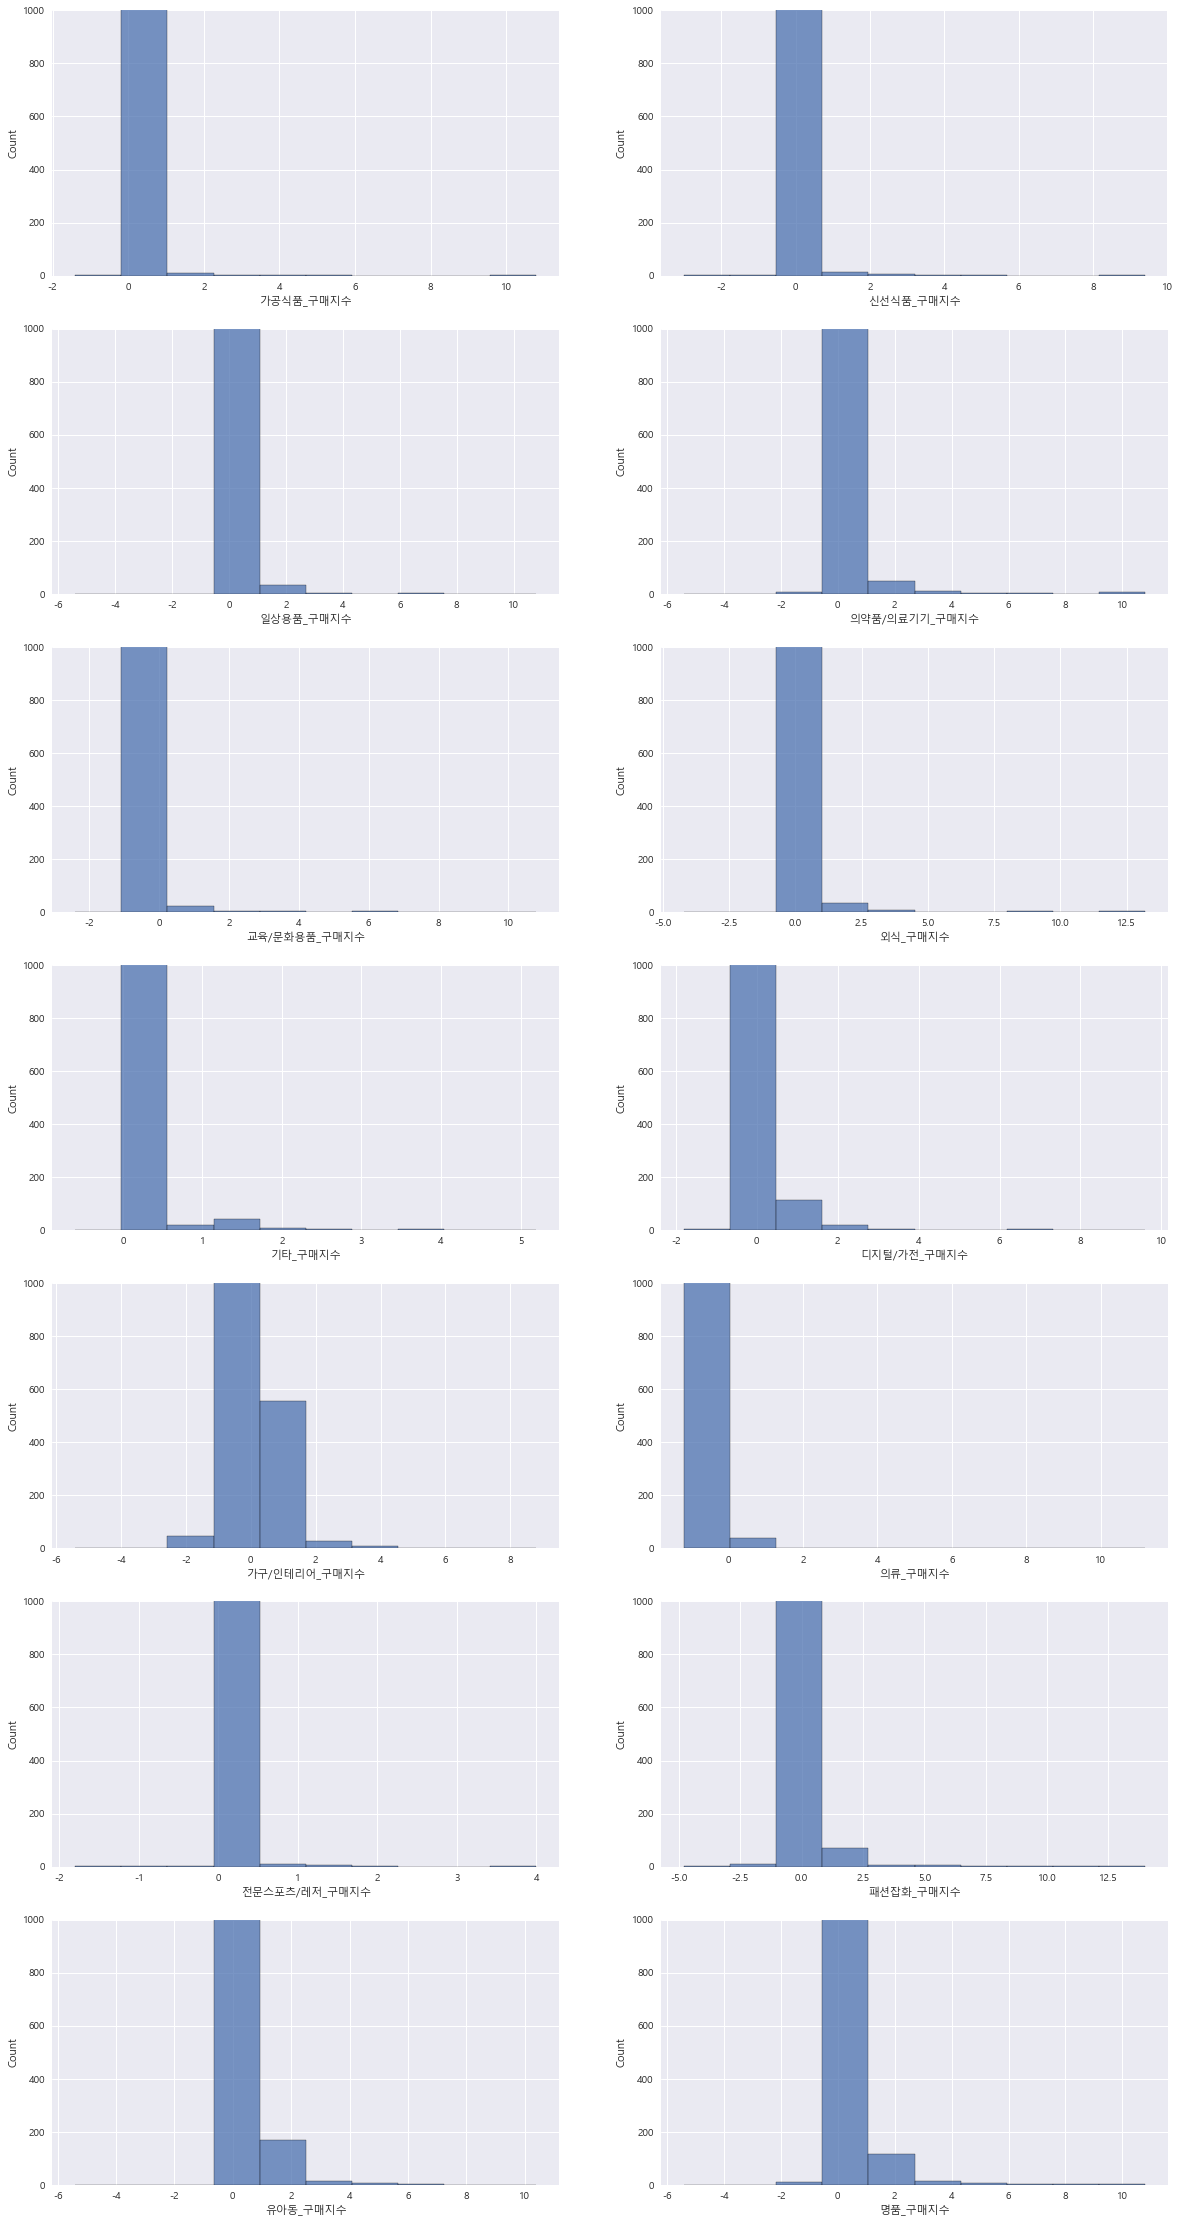

In [174]:
fig = plt.figure(figsize = (20, 40))
for i,j  in enumerate(df_final.columns.tolist()[1:]):
    fig.add_subplot(7, 2, i+1)
    sns.histplot(df_final[f'{j}'], bins = 10)
    plt.ylim(0, 1000)
#     plt.title(f'{j}', fontsize = 15)
    plt.show

#### # 매출액 로그변환 데이터
---

In [149]:
#복사본 생성, 계절성 제거
df_quarter=df_all_p.copy()
df_quarter['총구매액'] = np.log1p(df_quarter['총구매액'])

# 결과물을 위한 데이터 프레임
custom = pd.Series(df_quarter.고객번호.unique())

df_result=pd.DataFrame(data=custom,columns=['고객번호']) 
df_final=pd.DataFrame(data=custom,columns=['고객번호']) 

labels=['가공식품','신선식품','일상용품','의약품/의료기기','교육/문화용품','외식','기타',
       '디지털/가전','가구/인테리어','의류','전문스포츠/레저','패션잡화','유아동',
       '명품']

for label in labels:
    for i in df_quarter.기.unique():
        df_temp=df_quarter[(df_quarter.기==i) & (df_quarter.분류==label)]
        df_temp=df_temp.reset_index()
#       df_result[f'{label}_{i}구매'] = df_temp['총구매액']
        range_ = (df_temp['총구매액'].min(), df_temp['총구매액'].max())
        df_result[f"{label}_{i}"] = pd.cut(df_temp['총구매액'], 
                                           bins=10, 
                                        labels=[1,2,3,4,5,6,7,8,9,10]).astype("int")

    df_result[f'{label}_증감'] = df_result[f"{label}_7기"]-df_result[f"{label}_1기"]
    df_result[f'{label}_변동']=abs(df_result[f'{label}_2기']-df_result[f'{label}_1기'])+\
    abs(df_result[f'{label}_3기']-df_result[f'{label}_2기'])+\
    abs(df_result[f'{label}_4기']-df_result[f'{label}_3기'])+\
    abs(df_result[f'{label}_5기']-df_result[f'{label}_4기'])+\
    abs(df_result[f'{label}_6기']-df_result[f'{label}_5기'])+\
    abs(df_result[f'{label}_7기']-df_result[f'{label}_6기'])+\
    abs(df_result[f'{label}_8기']-df_result[f'{label}_7기'])
    df_final[f'{label}_구매지수']=df_result[f'{label}_증감']*0.8+df_result[f'{label}_변동']*0.2
#     df_result['구매액지수']=df_result['증감']*0.8+df_result['변동']*0.2

In [151]:
df_final

,고객번호,가공식품_구매지수,신선식품_구매지수,일상용품_구매지수,의약품/의료기기_구매지수,교육/문화용품_구매지수,외식_구매지수,기타_구매지수,디지털/가전_구매지수,가구/인테리어_구매지수,의류_구매지수,전문스포츠/레저_구매지수,패션잡화_구매지수,유아동_구매지수,명품_구매지수
0,00001,0.4,0.4,-2.6,2.4,0.0,0.6,0.0,11.6,0.6,0.4,0.0,1.0,-1.4,2.4
1,00002,0.4,0.0,1.0,2.8,0.0,0.4,0.0,9.2,6.6,0.8,0.0,0.6,7.8,2.8
2,00003,0.0,0.0,2.2,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.8,0.0,0.0
3,00004,0.0,0.0,0.6,5.6,0.0,1.4,0.0,0.0,10.0,1.4,4.8,1.8,4.4,0.0
4,00006,0.0,1.4,0.4,0.0,4.0,0.8,0.0,0.0,10.2,0.4,3.2,9.6,-2.4,8.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18861,19333,0.0,-3.0,-2.0,0.0,-3.6,0.4,0.0,0.0,0.0,-3.0,-3.0,0.0,1.6,0.0
18862,19334,-0.2,0.0,-0.2,4.4,5.6,0.0,0.0,0.0,2.0,3.0,3.6,2.0,3.8,0.0
18863,19335,1.0,0.0,1.0,2.4,2.0,1.0,0.0,1.0,0.4,0.4,5.4,1.4,1.0,0.0
18864,19336,10.8,8.0,8.2,0.0,0.0,1.4,0.0,0.0,1.2,7.0,0.0,0.8,11.6,8.4


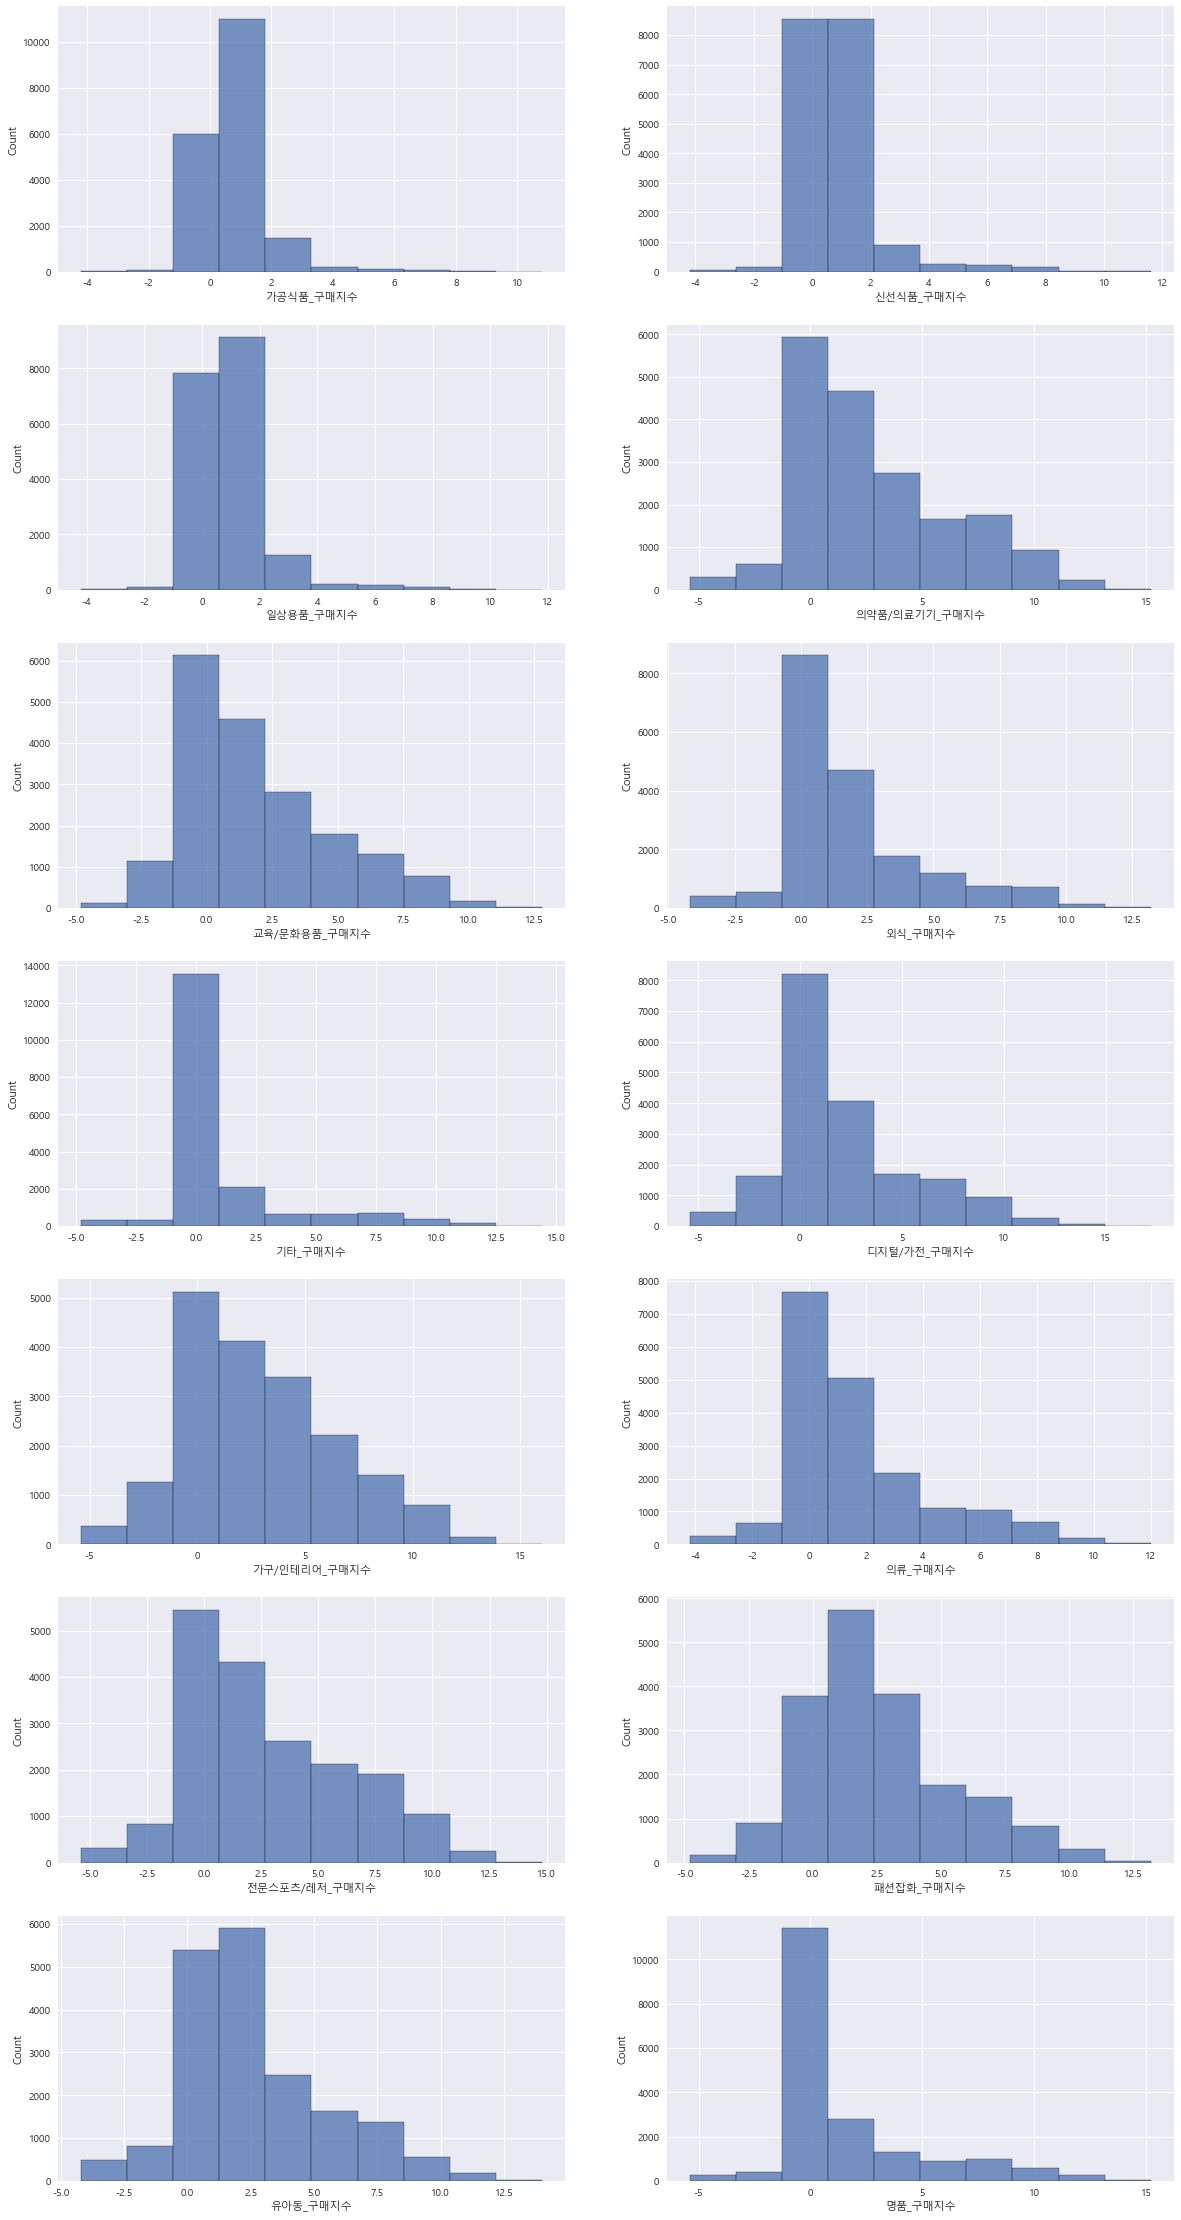

In [164]:
fig = plt.figure(figsize = (20, 40))
for i,j  in enumerate(df_final.columns.tolist()[1:]):
    fig.add_subplot(7, 2, i+1)
    sns.histplot(df_final[f'{j}'], bins = 10)
#     plt.title(f'{j}', fontsize = 15)
    plt.show

### # 구매횟수 지수화
---

In [111]:
a = [0 ,0, 0, 1, 2, 2, 3, 4, 4, 5, 6, 7, 8, 9, 10, 10]
df1 = pd.DataFrame(a)

df1['label'] = pd.cut(df1[0],
                      bins = 4,
                      labels = [1, 2, 3, 4])
df1

,0,label
0,0,1
1,0,1
2,0,1
3,1,1
4,2,1
5,2,1
6,3,2
7,4,2
8,4,2
9,5,2


### # 매출의 분포 확인하기
---

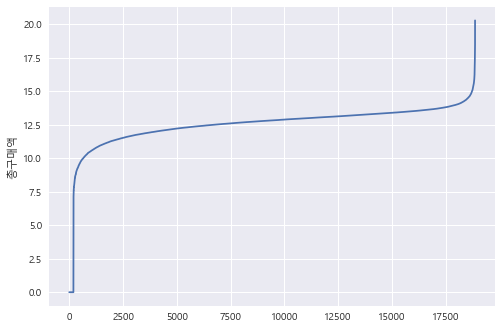

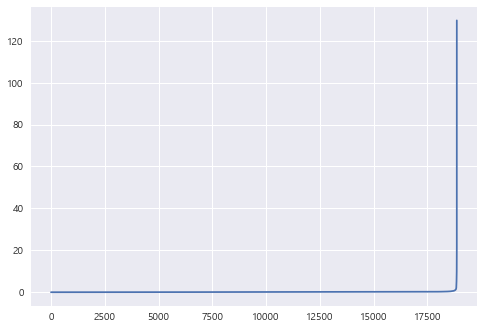

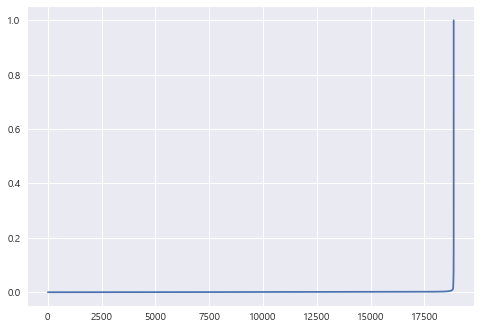

In [264]:
a = df_all_p.loc[(df_all_p['분류'] == '가공식품') & (df_all_p['기'] == '1기')]
b = a.sort_values('총구매액')

sns.lineplot(x = range(18866), y = np.log1p(b['총구매액']))
plt.show()
sns.lineplot(x = range(18866), y = StandardScaler().fit_transform(b[['총구매액']]).reshape(-1))
plt.show()
sns.lineplot(x = range(18866), y = MinMaxScaler().fit_transform(b[['총구매액']]).reshape(-1))
plt.show()

In [92]:
df_all_re

,고객번호,분류,기,총구매액
0,00001,가공식품,1기,0
14,00001,가공식품,2기,0
28,00001,가공식품,3기,0
42,00001,가공식품,4기,0
56,00001,가공식품,5기,0
...,...,...,...,...
2112932,19337,패션잡화,4기,0
2112946,19337,패션잡화,5기,0
2112960,19337,패션잡화,6기,0
2112974,19337,패션잡화,7기,0


In [ ]:
for i in cusno:
    for j in cat:
        for k in season:
            df_all_re.loc[(df_all_re['고객번호'] == i) & (df_all_re['분류'] == j) & (df_all_re['기'] == k), '총구매액'] = df_all_scaled.loc[(df_all_scaled['고객번호'] == i) & (df_all_scaled['분류'] == j) & (df_all_scaled['기'] == k), '총구매액']

In [ ]:
for i in ['2-1','3-2','4-3','5-4','6-5','7-6','8-7']:
    if df_temp = df_result[df_result[f'{i}']<0]:
        df_temp[f'{i}']=abs(df_temp[f'{i}'])
        df_result[f"{i}가중치"] = pd.cut(df_temp[f'{i}'], 
                                           bins=[-1, 
                                                 np.percentile(df_temp[f'{i}'], 20), 
                                                 np.percentile(df_temp[f'{i}'], 40),
                                                 np.percentile(df_temp[f'{i}'], 60), 
                                                 np.percentile(df_temp[f'{i}'], 80), 
                                                 df_temp[f'{i}'].max()], 
                                        labels=[-0.1,-0.2,-0.3,-0.4,-0.5]).astype("float")
        
    elif df_temp = df_result[df_result[f'{i}']>0]:
    #     df_temp[f'{i}']=abs(df_temp[f'{i}'])
        df_result_1[f"{i}가중치"] = pd.cut(df_temp[f'{i}'], 
                                           bins=[-1, 
                                                 np.percentile(df_temp[f'{i}'], 20), 
                                                 np.percentile(df_temp[f'{i}'], 40),
                                                 np.percentile(df_temp[f'{i}'], 60), 
                                                 np.percentile(df_temp[f'{i}'], 80), 
                                                 df_temp[f'{i}'].max()], 
                                        labels=[0.1,0.2,0.3,0.4,0.5]).astype("float")

In [ ]:
SELECT a.고객번호,a.분류등급, a.세분류명, b.고객구분, a.기, sum(a.구매금액) "총구매액"
FROM LCL2 a 
JOIN 고정고객 b ON a.고객번호 = b.고객번호
where 분류등급 = '일상용품_상'
GROUP BY a.고객번호, a.분류등급, a.세분류명, b.고객구분, a.기
ORDER BY a.고객번호, a.분류등급, b.고객구분, a.기